In [50]:
# Importing Libraries 
import cv2
import numpy as np 
import os 
import pickle 
from matplotlib import pyplot as plt
%matplotlib inline 

In [51]:
# Defining Image Paths 
images_left_dir = 'assignment2_stereodata/images_left'
images_right_dir = 'assignment2_stereodata/images_right'

In [52]:
# Function for feature inlier feature detection

def SIFT_feature_match(im_left, im_right):

    sift = cv2.SIFT_create()

    # Extract features
    kp1, des1 = sift.detectAndCompute(im_left, None) 
    kp2, des2 = sift.detectAndCompute(im_right, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True) # for ORB (use distance "cv2.NORM_L2" for SIFT)

    # Perform matching using extracted descriptors
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance) # sort from best to worst
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])


    # Find inliers 
    F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC)

    # retain only points which were inliers (specified by "mask")
    pts1_inliers = pts1[mask[:,0]==1]
    pts2_inliers = pts2[mask[:,0]==1]

    return pts1_inliers, pts2_inliers



Text(0.5, 0.92, 'Reference Terrain Model')

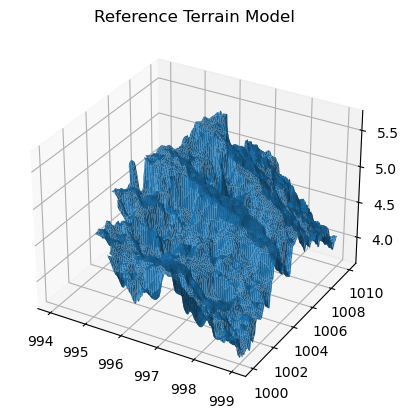

In [53]:
# Read in the Calibration Results 
with open('assignment2_stereodata/camera_pose_data.pkl', 'rb') as file:
    camera_pose_data = pickle.load(file)

R_camera = camera_pose_data["R"]
t_camera = camera_pose_data["t"]
filenames_left = camera_pose_data["filenames_left"]
filenames_right = camera_pose_data["filenames_right"]


# Read in Stereo Calibration Data
with open('assignment2_stereodata/calib_stereo_diver.pkl', 'rb') as file:
    calibration_data = pickle.load(file)

D_left = calibration_data["Dl"]
K_left = calibration_data["Kl"]
D_right = calibration_data["Dr"]
K_right = calibration_data["Kr"]
R = calibration_data["R"]
t = calibration_data["t"]


# Read in the Terrain Data 
with open('assignment2_stereodata/terrain_data.pkl', 'rb') as file:
    terrain_data = pickle.load(file)

height_grid = terrain_data["height_grid"]
X = terrain_data["X"]
Y = terrain_data["Y"]





# Plot the Ground Truth Terrain Data 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(terrain_data['X'], terrain_data['Y'])
surf = ax.plot_surface(X, Y, -terrain_data['height_grid'], rstride=5, cstride=5)
ax.set_title("Reference Terrain Model")

In [54]:
# Creating arrays to store left and right images 

left_imgs = []
for image_name in filenames_left:
    left_imgs.append(cv2.imread(os.path.join(images_left_dir, image_name), cv2.IMREAD_GRAYSCALE))


right_imgs = []
for image_name in filenames_right:
    right_imgs.append(cv2.imread(os.path.join(images_right_dir, image_name), cv2.IMREAD_GRAYSCALE))



found 1000 and 1000 feature points ...


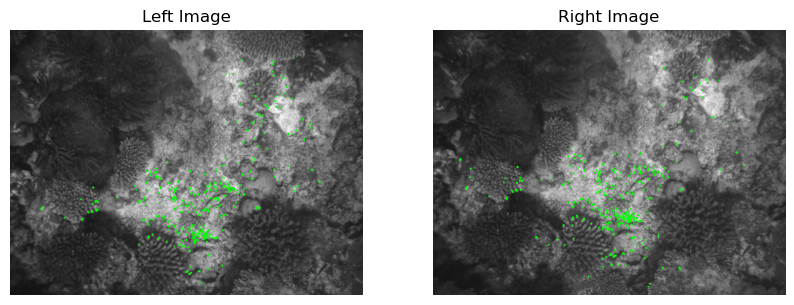

In [55]:
# Extract features - ORB
orb = cv2.ORB_create(nfeatures=1000) # "nfeatures" controls the sensitivity of how many features we want to extract
kp1, des1 = orb.detectAndCompute(left_imgs[20], None) # second parameter is a mask image (only extract points inside mask)
kp2, des2 = orb.detectAndCompute(right_imgs[20], None)
print('found %d and %d feature points ...'%(len(kp1),len(kp2)))
# kp: keypoints (image location of feature), des: descriptor: ORB feature descriptor for each keypoint

# draw located keypoints
imglc = cv2.cvtColor(left_imgs[20], cv2.COLOR_GRAY2RGB)
imgrc = cv2.cvtColor(right_imgs[20], cv2.COLOR_GRAY2RGB)
for k in kp1:
    cv2.circle(imglc,(int(k.pt[0]), int(k.pt[1])),3,(0,255,0),-1)
for k in kp2:
    cv2.circle(imgrc,(int(k.pt[0]), int(k.pt[1])),3,(0,255,0),-1)

plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.imshow(imglc,'Greys')
plt.title('Left Image')
plt.gca().set_axis_off()

plt.subplot(122)
plt.imshow(imgrc,'Greys')
plt.title('Right Image')
plt.gca().set_axis_off()

plt.show()

found 8218 and 7775 feature points ...


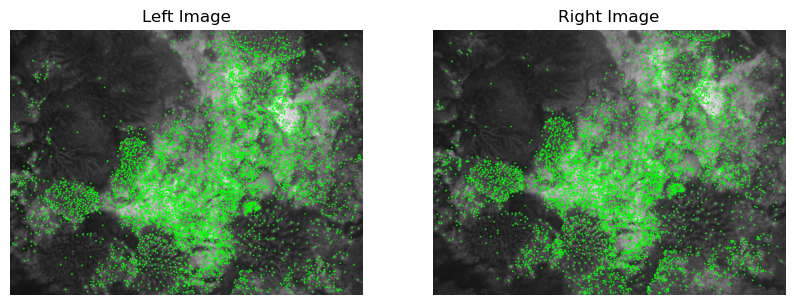

In [56]:
# SIFT FEATURE DETECTION 

im_left = left_imgs[20]
im_right = right_imgs[20]

sift = cv2.SIFT_create()

# Extract features
kp1, des1 = sift.detectAndCompute(im_left, None) 
kp2, des2 = sift.detectAndCompute(im_right, None)

print('found %d and %d feature points ...' % (len(kp1), len(kp2)))

# Draw located keypoints
imglc = cv2.cvtColor(im_left, cv2.COLOR_GRAY2RGB)
imgrc = cv2.cvtColor(im_right, cv2.COLOR_GRAY2RGB)
for k in kp1:
    cv2.circle(imglc, (int(k.pt[0]), int(k.pt[1])), 3, (0, 255, 0), -1)
for k in kp2:
    cv2.circle(imgrc, (int(k.pt[0]), int(k.pt[1])), 3, (0, 255, 0), -1)

plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.imshow(imglc)
plt.title('Left Image')
plt.gca().set_axis_off()

plt.subplot(122)
plt.imshow(imgrc)
plt.title('Right Image')
plt.gca().set_axis_off()

plt.show()


Found 5120 matches ...


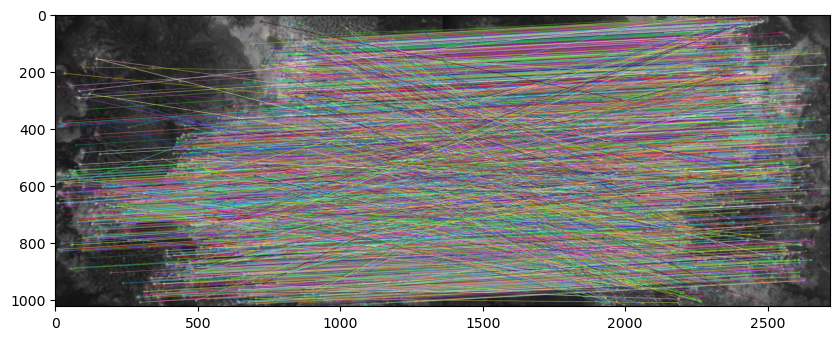

In [57]:
# initialise new matcher (cross-checker is used to only return matches that are the best in both views)
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True) # for ORB (use distance "cv2.NORM_L2" for SIFT)

# Perform matching using extracted descriptors
# Each "match" contains information about distance and the index from image 1 (queryIdx) and image 2 (trainIdx)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance) # sort from best to worst
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

print('Found %d matches ...'%(len(matches)))

# Display matches on screen using "cv2.drawMatches"
imgmatch = cv2.drawMatches(im_left,kp1,im_right,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 7))
plt.imshow(imgmatch)
plt.show()

Found 4505 inlier correspondances


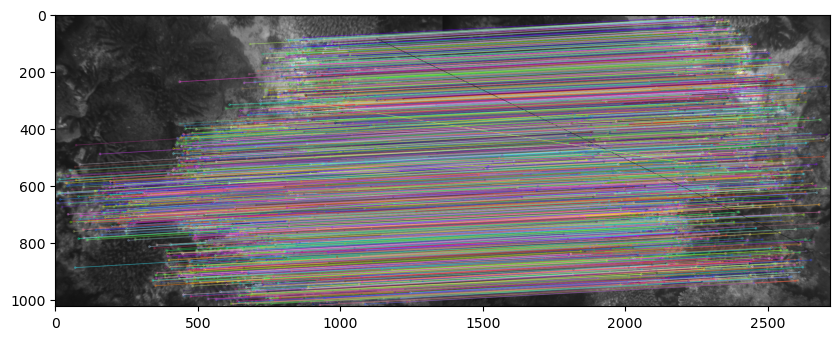

In [58]:
# Implementing Outlier Rejection 
# compute Fundamental Matrix F between the two views using correspondances via RANSAC
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC)

# retain only points which were inliers (specified by "mask")
pts1_inliers = pts1[mask[:,0]==1]
pts2_inliers = pts2[mask[:,0]==1]

print("Found %d inlier correspondances"%(pts1_inliers.shape[0]))

# filter original matches list for re-drawing
matches_inliers = []
for i in range(mask.shape[0]):
    if mask[i,0] == 1:
        matches_inliers.append(matches[i])

# Display matches on screen using "cv2.drawMatches"
imgmatch = cv2.drawMatches(im_left,kp1,im_right,kp2,matches_inliers,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 7))
plt.imshow(imgmatch)
plt.show()

In [ ]:
# Run feature detector on all stereo image pairs 
 
all_left_points = []
all_right_points =[]

for i in range(len(left_imgs)):
    im_left = left_imgs[i]
    im_right = right_imgs[i]
    left_points, right_points = SIFT_feature_match(im_left, im_right)

    all_left_points.append(left_points)
    all_right_points.append(right_points)


all_right_points = np.array(np.vstack(all_right_points))
all_left_points = np.array(np.vstack(all_right_points))





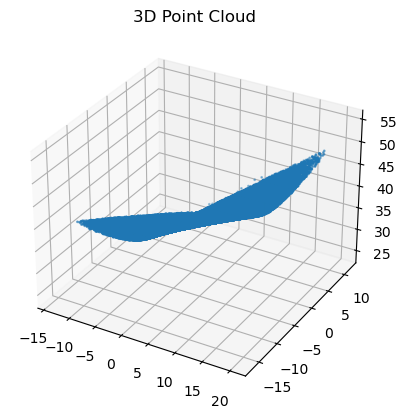

In [71]:
# Generating 3D terrain map 

P_left = (K_left)@ np.hstack((np.eye(3), np.zeros((3, 1)))) 
P_right = (K_right) @ np.hstack((R, t))  

pts1_h = all_left_points.T.astype(np.float32)
pts2_h = all_right_points.T.astype(np.float32)

points_4D = cv2.triangulatePoints(P_left, P_right, pts1_h, pts2_h)

points_3D = points_4D/points_4D[3]
points_3D = points_3D[:3,:]

points_3D = points_3D.T


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3D[:, 0], points_3D[:, 1], points_3D[:, 2], s=1)
ax.set_title("3D Point Cloud")
plt.show()